# Summary
This notebook replicates the interpretation of discovered subspaces in RNA-seq data using the additional patient clinical information.

In [1]:
import sys
sys.path.append("..")

#GPU configuration
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default

import random
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.cluster import adjusted_rand_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scripts.data_generator as data_generator
import scripts.feature_ranking as feature_ranking
import scripts.features_2d as features_2d
import scripts.ga as ga
import scripts.preprocess as preprocess
import scripts.ga_evaluation as ga_evaluation
import scripts.bio_analysis as bio_analysis
import tensorflow as tf
from IPython import get_ipython
from tqdm import tqdm
from collections import Counter

plt.ion()
plt.show()

random_state=0
random.seed( random_state )
np.random.seed(random_state)

%load_ext autoreload
%autoreload 2

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5



Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/scanpy/api/__init__.py:7: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning,


In [19]:
filename ="BRCA"
# filename ="KIRP"
# if filename == "KIRP":
#     ground_truth_subspace = 9
# else:
#     ground_truth_subspace = 1

In [20]:
ground_truth_column = {"BRCA":"breast_carcinoma_estrogen_receptor_status", "KIRP": "tumor_type"}
ground_truth_column = ground_truth_column[filename]
ground_truth_column

'breast_carcinoma_estrogen_receptor_status'

In [33]:
data = pd.read_pickle(f"../data/rna_data/{filename}.pkl")
additional_df = pd.read_pickle(f"../data/rna_data/{filename}_additional.pkl")
truth = data["y"].values
data = data.drop("y", axis = 1).values
n_clusters = len(np.unique(truth))
Counter(truth), data.shape

(Counter({1: 794, 0: 237}), (1031, 18054))

In [34]:
# additional_df = additional_df.rename(columns={ground_truth_column:'y'})

In [35]:
# method = "adapted_silhouette"
# clustering = "hdbscan"

In [36]:
clustering = "gmm"
method = "adapted_ratkowsky_lance"

In [37]:
solutions = pd.read_pickle(f"../data/{filename}_{clustering}_{method}.pkl")
solutions = ga.rank_solutions(solutions, data)
solutions

,adapted_ratkowsky_lance,ari,features,nmi,partition,point_biserial,silhouette,size,structure,davies_bouldin,davies_bouldin_silhouette,rank_silhouette,rank_point_biserial,rank_ari,rank_nmi
0,0.24,0.32,"[17460, 17463]",0.19,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, ...",0.23,0.65,2.0,"Counter({0: 734, 1: 297})",0.505510,10.0,1.0,4.0,3.0,3.0
1,0.25,0.68,"[362, 400, 401, 721, 988, 1330, 2062, 2295, 24...",0.52,"[1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, ...",0.61,0.50,40.0,"Counter({1: 780, 0: 251})",0.834492,7.0,4.0,1.0,1.0,1.0
2,0.23,0.09,"[13786, 13787, 13788]",0.07,"[1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, ...",0.17,0.49,3.0,"Counter({1: 571, 0: 460})",0.704748,6.0,5.0,5.0,5.0,5.0
3,0.24,0.40,"[1247, 1343, 1962, 2394, 3398, 3617, 5153, 524...",0.25,"[1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, ...",0.52,0.46,35.0,"Counter({1: 751, 0: 280})",0.874517,3.0,7.0,2.0,2.0,2.0
4,0.22,-0.02,"[44, 56, 57, 600, 824, 1103, 2579, 3051, 5874,...",0.02,"[1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, ...",0.30,0.39,15.0,"Counter({0: 647, 1: 384})",0.961990,1.0,10.0,3.0,10.0,6.0
5,0.23,0.16,"[4264, 4739, 10177, 11004, 12171]",0.11,"[1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, ...",0.16,0.46,5.0,"Counter({1: 627, 0: 404})",0.823624,3.0,7.0,6.0,4.0,4.0
6,0.22,0.02,"[2829, 5360, 8875]",0.00,"[1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, ...",0.15,0.48,3.0,"Counter({1: 641, 0: 390})",0.714829,5.0,6.0,7.0,7.0,9.0
7,0.22,0.06,"[7509, 7510, 7512, 11081, 11082, 17200]",0.02,"[1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, ...",0.15,0.41,6.0,"Counter({1: 651, 0: 380})",0.849415,2.0,9.0,7.0,6.0,6.0
8,0.22,0.00,"[9086, 11405]",0.00,"[1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, ...",0.14,0.56,2.0,"Counter({0: 534, 1: 497})",0.604524,9.0,2.0,10.0,8.0,9.0
9,0.22,0.00,"[1237, 2155]",0.02,"[0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, ...",0.15,0.53,2.0,"Counter({1: 567, 0: 464})",0.644295,8.0,3.0,7.0,8.0,6.0


In [38]:
ground_truth_subspace = solutions[solutions["rank_ari"] == 1].index.values[0]

In [39]:
subspaces = solutions["features"].values
partitions = solutions["partition"].values

# Number of missing clinical data


In [40]:
# (additional_df.isnull().sum()/additional_df.shape[0]).mean()

In [41]:
additional_results, best_subspace_match, best_meta_subspace = bio_analysis.clinical_data_analysis(
    additional_df, solutions, n_clusters)

Found 2 values for vital_status
Clustering numeric values for days_to_death
Clustering numeric values for days_to_last_followup
No more than 1 class found for additional_studies
Found 3 values for additional_surgery_locoregional_procedure
No more than 1 class found for additional_surgery_metastatic_procedure
Clustering numeric values for age_at_initial_pathologic_diagnosis
Found 11 values for anatomic_neoplasm_subdivision-2
Found 9 values for anatomic_neoplasm_subdivision-3
Found 6 values for anatomic_neoplasm_subdivision-4
Found 5 values for anatomic_neoplasm_subdivision-5
Found 10 values for anatomic_neoplasm_subdivision
Found 6 values for axillary_lymph_node_stage_method_type
Found 19 values for axillary_lymph_node_stage_other_method_descriptive_text
No more than 1 class found for b_symptoms
No more than 1 class found for bcr
Found 3 values for bcr_canonical_reason-2
No more than 1 class found for bcr_canonical_reason-3
Found 6 values for bcr_canonical_reason
Found 942 values for bc

In [42]:
best_subspace_match["additional_data"].unique()

array(['breast_carcinoma_estrogen_receptor_status',
       'bcr_canonical_reason-2', 'metastatic_site_at_diagnosis-2',
       'bcr_canonical_reason', 'metastatic_site_at_diagnosis_other',
       'additional_surgery_locoregional_procedure'], dtype=object)

In [43]:
maping = {
    'breast_carcinoma_estrogen_receptor_status': "Carcinoma Estrogen Receptor",
    'metastatic_site_at_diagnosis-2': "Metastatic site 2",
    'bcr_canonical_reason': "Canonical reason",
    'anatomic_neoplasm_subdivision-4': "Neoplasm subdivision 4",
    'pos_finding_her2_erbb2_other_measurement_scale_text': "Her2 Erbb2",
    'bcr_canonical_reason-2': "Canonical reason 2",
    "days_to_additional_surgery_metastatic_procedure":
    "Days to additional surgery",
    "metastatic_site_at_diagnosis_other": "Metastatic site",
    'bcr_patient_canonical_status': "BCR Canonical Status",
    'bcr_canonical_reason-2': "BCR Canonical Reason 2",
    'erythrocyte_sedimentation_rate_result': "Erythrocyte Sedimentation",
    'gender': "Gender",
    'clinical_stage': "Clinical Stage",
    'karnofsky_performance_score': "Karnofsky performance",
    'serum_calcium_result': "Serum Calcium Result",
    'lymph_node_examined_count': "Lymph count",
    'eastern_cancer_oncology_group': "Eastern oncology group",
    'days_to_death': "Days to death",
    'year_of_tobacco_smoking_onset': "Year smoking onset",
    'followup_treatment_success': "Followup treatment success",
    'performance_status_scale_timing': "Status Scale Timing",
    "additional_surgery_locoregional_procedure": "Additional Locoregional Procedure",
    "number_of_lymphnodes_positive": "Nb positives lymphnodes",
    "lactate_dehydrogenase_result": "Lactate dehydrogenase"
}

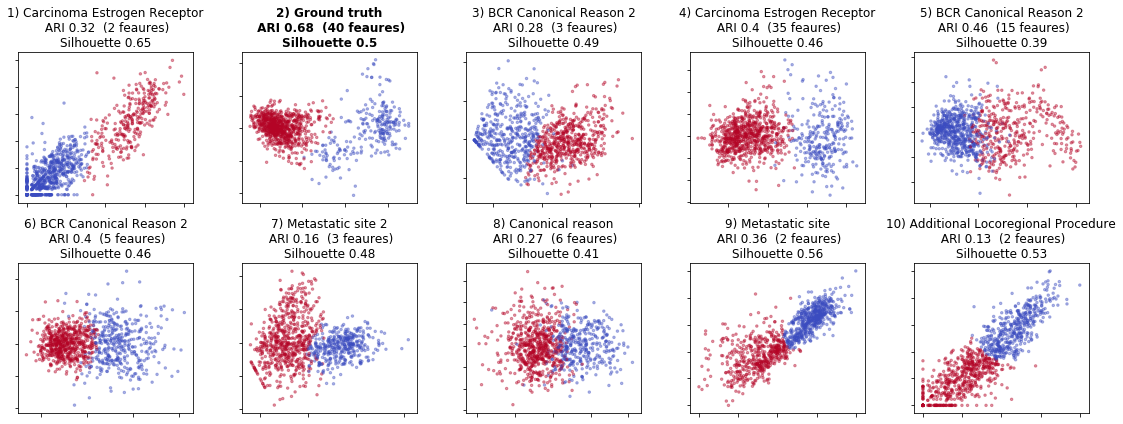

In [44]:
bio_analysis.plot_subspaces_with_best_meta(solutions,
                                           best_subspace_match,
                                           data,
                                           ground_truth_subspace,
                                           maping,
                                           do_pca=True,
                                           filename =  f"../images/{filename}_subspaces_PCA.jpg")

In [ ]:
bio_analysis.plot_prediction_vs_ground_truth(ground_truth_subspace, solutions, data, truth, do_pca = True,
            filename = f"../images/{filename}_pred_vs_gt.pdf")


In [ ]:
bio_analysis.solutions_to_survival_analysis(
    additional_df, solutions, f"../data/rna_data/{filename}_survival.pkl")

In [ ]:
pdf_name =f"reports/{filename}.pdf"
bio_analysis.plot_pca_subspaces(data, solutions, method, truth, pdf_name = None, name = filename)

In [ ]:
merged = bio_analysis.merge_subspaces(solutions, method, data, n_clusters, truth)

# Gender analysis

In [ ]:
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import fcluster, linkage
from sklearn import cluster, datasets, mixture

In [ ]:
c = 'gender'

additional_df['gender' ].isnull().sum()

not_null_idx = additional_df[~additional_df[c].isnull(
            )].index.values

labels = preprocessing.LabelEncoder().fit_transform(
                    additional_df[c].values[not_null_idx])

In [ ]:
# for i in range(20):
#     print(i, adjusted_rand_score(labels, solutions.iloc[i]['partition']))

In [ ]:
sid = 3

target_subspace = solutions.iloc[sid]['features']

adjusted_rand_score(labels, solutions.iloc[sid]['partition']), len(target_subspace)

In [ ]:
labels = np.abs(labels -1)

In [ ]:
mislabelled = np.where(labels!= solutions.iloc[sid]['partition'])[0]

In [ ]:
len(mislabelled)

In [ ]:
do_pca = True
data_x = data[:, target_subspace]
if do_pca:
    pca_data = PCA(n_components=2).fit_transform(data_x)
else:
    pca_data = TSNE(n_components=2).fit_transform(data_x)

In [ ]:
plt.scatter(pca_data[:, 0], pca_data[:, 1], c= solutions.iloc[sid]['partition'], 
            cmap = "coolwarm", alpha = 0.6, s = 15)
plt.scatter(pca_data[mislabelled, 0], pca_data[mislabelled, 1], c = "black", marker = '*', s =150) 
plt.title("Gender analysis")

plt.savefig("../images/gender_analysis.pdf", bbox_inches='tight')